In [1]:
from mads_datasets.base import BaseDatastreamer
from mltrainer.preprocessors import BasePreprocessor
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from torch import nn
import torch

from src import datasets, metrics
import mltrainer
mltrainer.__version__

'0.1.129'

In [35]:
import tomllib

datadir = Path('../data')
configfile = Path("config.toml")

with configfile.open('rb') as f:
    config = tomllib.load(f)
print(config)

{'ptb': 'heart', 'arrhythmia': 'heart_big'}


In [36]:
trainfile = datadir / (config['arrhythmia'] + '_SMOTE_train.parq')
testfile = datadir / (config['arrhythmia'] + '_test.parq')
trainfile, testfile

(PosixPath('../data/heart_big_train.parq'),
 PosixPath('../data/heart_big_test.parq'))

Load the data

In [4]:
# load data in dataframes
train_df = pd.read_parquet(trainfile)
test_df = pd.read_parquet(testfile)

In [37]:
traindataset = datasets.HeartDataset1D(trainfile, target="target")
testdataset = datasets.HeartDataset1D(testfile, target="target")
traindataset, testdataset

# moving to mps device crashes the jupyter kernel

(Heartdataset (len 87554), Heartdataset (len 21892))

In [6]:
x, y = traindataset[0]
x.shape



torch.Size([192, 1])

Visualise it as 1D data

torch.Size([192, 1]) tensor(0)


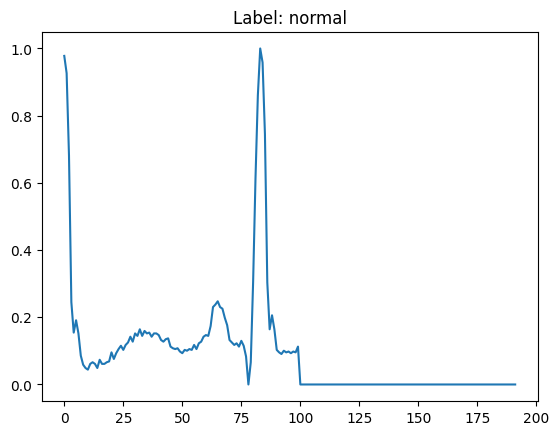

In [38]:
x, y = traindataset[0]
viz = x.squeeze().cpu().numpy()
sns.lineplot(x=range(len(viz)), y=viz)
title = 'normal' if y == 0 else 'abnormal'
plt.title(f"Label: {title}");
print(x.shape, y)

Set up the streamer

In [40]:
trainstreamer = BaseDatastreamer(traindataset, preprocessor = BasePreprocessor(), batchsize=32)
teststreamer = BaseDatastreamer(testdataset, preprocessor = BasePreprocessor(), batchsize=32)
len(trainstreamer), len(teststreamer)

(2736, 684)

Positional encoding to use with the transformer.

In [41]:
from torch import Tensor
import math

class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_seq_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_seq_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(1, max_seq_len, d_model)
        # batch, seq_len, d_model
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Arguments:
            x: Tensor, shape ``[batch_size, seq_len, embedding_dim]``
        """
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

Note, the layers have different assumptions about the data structure:
- streamer:         (batch, seq_len, channels)
- conv1d:           (batch, channels, seq_len)
- pos_encoding:     (batch, seq_len, channels)
- gru (batchfirst): (batch, seq_len, channels)
- attention:        (batch, seq_len, channels)

As you can see, its just the conv1d layer that expects channels as the second dimension. Using a conv1d layer you
will need to transpose the dimensions, I will show how to do that in the Transformer `forward` method.

Again, the strategy of creating a block helps us stack the architecture more easily.

In [42]:
class TransformerBlock(nn.Module):
    def __init__(self, hidden_size, num_heads, dropout):
        # feel free to change the input parameters of the constructor
        super(TransformerBlock, self).__init__()
        self.attention = nn.MultiheadAttention(
            embed_dim=hidden_size,
            num_heads=num_heads,
            dropout=dropout,
            batch_first=True,
        )
        self.ff = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
        )
        self.layer_norm1 = nn.LayerNorm(hidden_size)
        self.layer_norm2 = nn.LayerNorm(hidden_size)

    def forward(self, x):
        identity = x.clone() # skip connection
        x, _ = self.attention(x, x, x)
        x = self.layer_norm1(x + identity) # Add & Norm skip
        identity = x.clone() # second skip connection
        x = self.ff(x)
        x = self.layer_norm2(x + identity) # Add & Norm skip
        return x

class Transformer(nn.Module):
    def __init__(
        self,
        config: dict,
    ) -> None:
        super().__init__()
        self.conv1d = nn.Conv1d(
            in_channels=1,
            out_channels=config["hidden"],
            kernel_size=3,
            stride=2,
            padding=1,
        )
        self.pos_encoder = PositionalEncoding(config["hidden"], config["dropout"])

        # Create multiple transformer blocks
        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(config["hidden"], config["num_heads"], config["dropout"])
            for _ in range(config["num_blocks"])
        ])

        #self.out = nn.Linear(config["hidden"], config["output"])
        #extra dense layers
        self.out = nn.Sequential(
            nn.Linear(config["hidden"], config["hidden"]//2),
            nn.ReLU(),
            nn.Dropout(config["dropout"]),
            nn.Linear(config["hidden"]//2, config["output"]),
        )

    def forward(self, x: Tensor) -> Tensor:
        # streamer:         (batch, seq_len, channels)
        # conv1d:           (batch, channels, seq_len)
        # pos_encoding:     (batch, seq_len, channels)
        # attention:        (batch, seq_len, channels)
        x = self.conv1d(x.transpose(1, 2)) # flip channels and seq_len for conv1d
        x = self.pos_encoder(x.transpose(1, 2)) # flip back to seq_len and channels

        # Apply multiple transformer blocks
        for transformer_block in self.transformer_blocks:
            x = transformer_block(x)

        x = x.mean(dim=1) # Global Average Pooling
        x = self.out(x)
        return x

In [49]:
from src import models
config = {
    "hidden": 128,
    "dropout": 0.1,
    "output": 5,
    "num_heads": 8,
    "num_blocks": 2,
}
print(config)
model = models.Transformer(config)

{'hidden': 128, 'dropout': 0.1, 'output': 5, 'num_heads': 8, 'num_blocks': 2}


Model 1D
Transofrmer block with 16 hidden units
Dropout  0.1
heads 4

Transformer is 1D conv
1 block
1 positional encoding

In [12]:
x, y = next(trainstreamer.stream())
x.shape, y.shape

(torch.Size([32, 192, 1]), torch.Size([32]))

In [13]:
yhat = model(x)
yhat.shape

torch.Size([32, 5])

In [14]:
f1micro = metrics.F1Score(average='micro')
f1macro = metrics.F1Score(average='macro')
precision = metrics.Precision('micro')
recall = metrics.Recall('macro')
accuracy = metrics.Accuracy()

In [15]:
import mlflow
mlflow.set_tracking_uri("sqlite:///mads_exam.db")
mlflow.set_experiment("Transformer")

<Experiment: artifact_location='/Users/francesca/code_repo/MADS-exam-25/notebooks/mlruns/2', creation_time=1736969121395, experiment_id='2', last_update_time=1736969121395, lifecycle_stage='active', name='Transformer', tags={}>

In [16]:
# Check if MPS is available
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print('MPS is available')
else:
    device = torch.device('cpu')

MPS is available


In [17]:
print(f"Model is on device: {next(model.parameters()).device}")


Model is on device: cpu


In [26]:
import logging
from mltrainer import TrainerSettings, ReportTypes

loss_fn = torch.nn.CrossEntropyLoss()

model = model.to(device)

with mlflow.start_run():
    
    optimizer = torch.optim.Adam

    settings = TrainerSettings(
        device=device,
        epochs=15,
        metrics=[accuracy, f1micro, f1macro, precision, recall],
        logdir="logs/heart1D",
        train_steps=len(trainstreamer) //5,
        valid_steps=len(teststreamer) //5,
        reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.MLFLOW],
        scheduler_kwargs={"factor": 0.5, "patience": 2},
        earlystop_kwargs=None
    )

    mlflow.set_tag("model", "Transfomer")
    mlflow.set_tag("dataset", "heart_small_binary")
    mlflow.log_params(config)
    mlflow.log_param("epochs", settings.epochs)
    mlflow.log_param("optimizer", str(optimizer))
    mlflow.log_param("scheduler", "None")
    mlflow.log_param("earlystop", "None")
    mlflow.log_params(settings.optimizer_kwargs)

    trainer = Trainer(
        model=model,
        settings=settings,
        loss_fn=loss_fn,
        optimizer=optimizer,
        traindataloader=trainstreamer.stream(),
        validdataloader=teststreamer.stream(),
        scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau,
        )
    trainer.loop()

100%|██████████| 905/905 [00:09<00:00, 92.40it/s]
INFO:__main__:Epoch 0 train 0.1720 test 2.9297 metric ['0.4239', '0.4239', '0.1856', '0.4239', '0.2441']
100%|██████████| 905/905 [00:09<00:00, 93.99it/s]
INFO:__main__:Epoch 1 train 0.1606 test 4.3845 metric ['0.3419', '0.3419', '0.1427', '0.3419', '0.2053']
100%|██████████| 905/905 [00:09<00:00, 94.20it/s]
INFO:__main__:Epoch 2 train 0.1469 test 5.1491 metric ['0.4216', '0.4216', '0.1729', '0.4216', '0.2223']
100%|██████████| 905/905 [00:09<00:00, 93.36it/s]
INFO:__main__:Epoch 3 train 0.1354 test 3.9765 metric ['0.2569', '0.2569', '0.1381', '0.2569', '0.2028']
100%|██████████| 905/905 [00:09<00:00, 92.80it/s]
INFO:__main__:Epoch 4 train 0.1127 test 6.9615 metric ['0.2518', '0.2518', '0.1175', '0.2518', '0.1957']
100%|██████████| 905/905 [00:09<00:00, 92.54it/s]
INFO:__main__:Epoch 5 train 0.1097 test 8.4230 metric ['0.3440', '0.3440', '0.1447', '0.3440', '0.2068']
100%|██████████| 905/905 [00:09<00:00, 91.75it/s]
INFO:__main__:Epoch 

In [52]:
from mltrainer import Trainer, TrainerSettings, ReportTypes
#loss_fn = torch.nn.CrossEntropyLoss()
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)
model = model.to(device)

with mlflow.start_run():
    optimizer = torch.optim.Adam

    settings = TrainerSettings(
        device=device,
        epochs=30,
        metrics=[accuracy, f1micro, f1macro, precision, recall],
        logdir="logs/heart1D",
        train_steps=len(trainstreamer) //5,
        valid_steps=len(teststreamer) //5,
        reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.MLFLOW],
        scheduler_kwargs={"factor": 0.5, "patience": 2},
        #scheduler_kwargs=None,
        earlystop_kwargs=None
    )

    mlflow.set_tag("model", "Transfomer")
    mlflow.set_tag("dataset", "heart_small_binary")
    mlflow.log_params(config)
    mlflow.log_param("epochs", settings.epochs)
    mlflow.log_param("optimizer", str(optimizer))
    mlflow.log_param("scheduler", "ReduceLROnPlateau")
    mlflow.log_param("earlystop", "None")
    mlflow.log_params(settings.optimizer_kwargs)

    trainer = Trainer(
        model=model,
        settings=settings,
        loss_fn=loss_fn,
        optimizer=optimizer,
        #traindataloader=trainstreamer.stream(),
        #validdataloader=teststreamer.stream(),
        traindataloader=((x.to(device), y.to(device)) for x, y in trainstreamer.stream()),
        validdataloader=((x.to(device), y.to(device)) for x, y in teststreamer.stream()),
        scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau,
        
        )
    trainer.loop()

2025-01-18 23:57:24.709 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to logs/heart1D/20250118-235724
100%|██████████| 547/547 [00:09<00:00, 55.10it/s]
2025-01-18 23:57:35.752 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 0.2292 test 4.6028 metric ['0.1117', '0.1117', '0.0629', '0.1117', '0.2718']
100%|██████████| 547/547 [00:09<00:00, 55.21it/s]
2025-01-18 23:57:46.802 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 0.1967 test 2.6533 metric ['0.6723', '0.6723', '0.2986', '0.6723', '0.3949']
100%|██████████| 547/547 [00:09<00:00, 55.01it/s]
2025-01-18 23:57:57.846 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.1866 test 3.8764 metric ['0.3389', '0.3389', '0.1814', '0.3389', '0.3312']
100%|██████████| 547/547 [00:09<00:00, 54.98it/s]
2025-01-18 23:58:08.936 | INFO     | mltrainer.trainer:report:191 - Epoch 3 train 0.1793 test 3.3653 metric ['0.7135', '0.7135', '0.2974', '0.7135', '0.3749']
100%|██████████| 547/547 [00:09<00:00, 55.15it

[Text(0.5, 23.52222222222222, 'Predicted'),
 Text(50.722222222222214, 0.5, 'Target')]

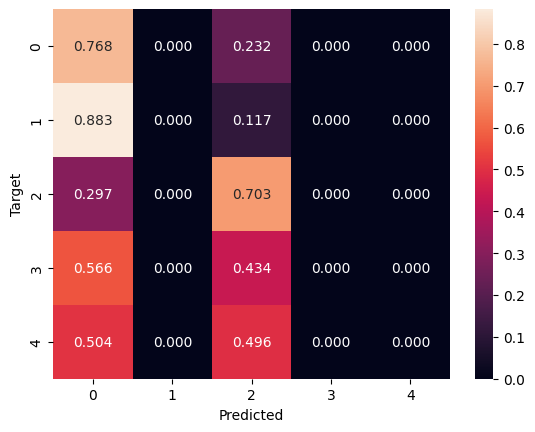

In [57]:
import numpy as np

y_true = []
y_pred = []

testdata = teststreamer.stream()
for _ in range(len(teststreamer)):
    X, y = next(testdata)
    X, y = X.to(device), y.to(device)
    yhat = model(X)
    yhat = yhat.argmax(dim=1) # we get the one with the highest probability
    y_pred.append(yhat.cpu().tolist())
    y_true.append(y.cpu().tolist())

yhat = [x for y in y_pred for x in y]
y = [x for y in y_true for x in y]

cfm = confusion_matrix(y, yhat)
cfm = cfm / np.sum(cfm, axis=1, keepdims=True)

plot = sns.heatmap(cfm, annot=cfm, fmt=".3f")
plot.set(xlabel="Predicted", ylabel="Target")

In [46]:
from mltrainer import Trainer, TrainerSettings, ReportTypes
loss_fn = torch.nn.CrossEntropyLoss()

with mlflow.start_run():
    optimizer = torch.optim.Adam

    settings = TrainerSettings(
        epochs=5,
        metrics=[accuracy, f1micro, f1macro, precision, recall],
        logdir="logs/heart1D",
        train_steps=len(trainstreamer) //5,
        valid_steps=len(teststreamer) //5,
        reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.MLFLOW],
        scheduler_kwargs=None,
        earlystop_kwargs=None
    )

    mlflow.set_tag("model", "Transfomer")
    mlflow.set_tag("dataset", "heart_small_binary")
    mlflow.log_params(config)
    mlflow.log_param("epochs", settings.epochs)
    mlflow.log_param("optimizer", str(optimizer))
    mlflow.log_param("scheduler", "None")
    mlflow.log_param("earlystop", "None")
    mlflow.log_params(settings.optimizer_kwargs)

    trainer = Trainer(
        model=model,
        settings=settings,
        loss_fn=loss_fn,
        optimizer=optimizer,
        traindataloader=trainstreamer.stream(),
        validdataloader=teststreamer.stream(),
        scheduler=None,
        )
    trainer.loop()

2025-01-18 21:21:42.610 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to logs/heart1D/20250118-212142
  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 905/905 [00:14<00:00, 60.35it/s]
2025-01-18 21:21:58.525 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 0.2196 test 0.1536 metric ['0.9554', '0.9554', '0.8148', '0.9554', '0.8911']
100%|██████████| 905/905 [00:15<00:00, 58.96it/s]
2025-01-18 21:22:14.800 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 0.2079 test 0.1478 metric ['0.9517', '0.9517', '0.8050', '0.9517', '0.8857']
100%|██████████| 905/905 [00:15<00:00, 58.88it/s]
2025-01-18 21:22:31.084 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.1988 test 0.2128 metric ['0.9329', '0.9329', '0.7672', '0.9329', '0.9012']
100%|██████████| 905/905 [00:15<00:00, 59.17it/s]
2025-01-18 21:22:47.290 | INFO     | mltrainer.trainer:report:191 - Epoch 3 train 0.1881 test 0.1315 metric ['0.9600', '0.9600', '0.8411', '0.9600', '0.9104']
100%|██████████| 905/905 [00:15<00:00, 58.91it/s]
2025-01-18 21:23:03.584 | INFO     | mltrainer.trainer:report:191 - Epoch 4 train 0.1817 test 0.2283 metric ['0.92

[Text(0.5, 23.52222222222222, 'Predicted'),
 Text(50.722222222222214, 0.5, 'Target')]

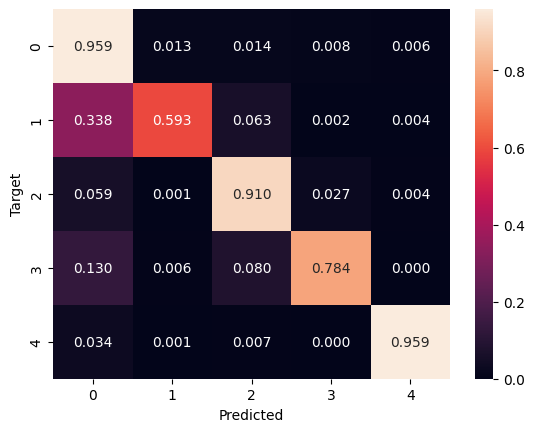

In [ ]:
import seaborn as sns
import numpy as np

y_true = []
y_pred = []

testdata = teststreamer.stream()
for _ in range(len(teststreamer)):
    X, y = next(testdata)
    yhat = model(X)
    yhat = yhat.argmax(dim=1) # we get the one with the highest probability
    y_pred.append(yhat.cpu().tolist())
    y_true.append(y.cpu().tolist())

yhat = [x for y in y_pred for x in y]
y = [x for y in y_true for x in y]

cfm = confusion_matrix(y, yhat)
cfm = cfm / np.sum(cfm, axis=1, keepdims=True)

plot = sns.heatmap(cfm, annot=cfm, fmt=".3f")
plot.set(xlabel="Predicted", ylabel="Target")

In [ ]:
from mltrainer import Trainer, TrainerSettings, ReportTypes
loss_fn = torch.nn.CrossEntropyLoss()

with mlflow.start_run():
    optimizer = torch.optim.Adam

    settings = TrainerSettings(
        epochs=5,
        metrics=[accuracy, f1micro, f1macro, precision, recall],
        logdir="logs/heart1D",
        train_steps=len(trainstreamer) //5,
        valid_steps=len(teststreamer) //5,
        reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.MLFLOW],
        scheduler_kwargs=None,
        earlystop_kwargs=None
    )

    mlflow.set_tag("model", "Transfomer")
    mlflow.set_tag("dataset", "heart_small_binary")
    mlflow.log_params(config)
    mlflow.log_param("epochs", settings.epochs)
    mlflow.log_param("optimizer", str(optimizer))
    mlflow.log_param("scheduler", "None")
    mlflow.log_param("earlystop", "None")
    mlflow.log_params(settings.optimizer_kwargs)

    trainer = Trainer(
        model=model,
        settings=settings,
        loss_fn=loss_fn,
        optimizer=optimizer,
        traindataloader=trainstreamer.stream(),
        validdataloader=teststreamer.stream(),
        scheduler=None,
        )
    trainer.loop()

2025-01-15 20:25:21.473 | INFO     | mltrainer.settings:check_path:61 - Created logdir /Users/francesca/code_repo/MADS-exam-25/notebooks/logs/heart1D
2025-01-15 20:25:21.484 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to logs/heart1D/20250115-202521
100%|██████████| 547/547 [00:04<00:00, 110.98it/s]
2025-01-15 20:25:27.246 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 0.6697 test 0.5468 metric ['0.8203', '0.8203', '0.2576', '0.8203', '0.2839']
100%|██████████| 547/547 [00:04<00:00, 111.69it/s]
2025-01-15 20:25:32.709 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 0.4691 test 0.3629 metric ['0.9046', '0.9046', '0.5638', '0.9046', '0.5641']
100%|██████████| 547/547 [00:04<00:00, 111.83it/s]
2025-01-15 20:25:38.163 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.3797 test 0.3620 metric ['0.8989', '0.8989', '0.5795', '0.8989', '0.5814']
100%|██████████| 547/547 [00:04<00:00, 111.29it/s]
2025-01-15 20:25:43.637 | INFO     | mltrainer.trai

[Text(0.5, 23.52222222222222, 'Predicted'),
 Text(50.722222222222214, 0.5, 'Target')]

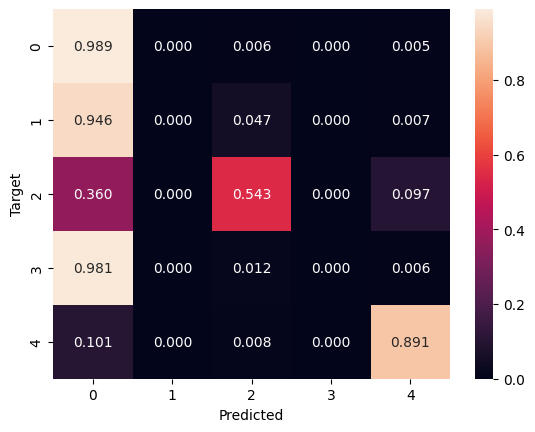

In [16]:
import seaborn as sns
import numpy as np

y_true = []
y_pred = []

testdata = teststreamer.stream()
for _ in range(len(teststreamer)):
    X, y = next(testdata)
    yhat = model(X)
    yhat = yhat.argmax(dim=1) # we get the one with the highest probability
    y_pred.append(yhat.cpu().tolist())
    y_true.append(y.cpu().tolist())

yhat = [x for y in y_pred for x in y]
y = [x for y in y_true for x in y]

cfm = confusion_matrix(y, yhat)
cfm = cfm / np.sum(cfm, axis=1, keepdims=True)

plot = sns.heatmap(cfm, annot=cfm, fmt=".3f")
plot.set(xlabel="Predicted", ylabel="Target")

In [20]:
from src import models
config = {
    "hidden": 32,
    "dropout": 0.1,
    "output": 5,
    "num_heads": 4,
    "num_blocks": 2,
}
model = models.Transformer(config)

In [21]:
from mltrainer import Trainer, TrainerSettings, ReportTypes
loss_fn = torch.nn.CrossEntropyLoss()

with mlflow.start_run():
    optimizer = torch.optim.Adam

    settings = TrainerSettings(
        epochs=5,
        metrics=[accuracy, f1micro, f1macro, precision, recall],
        logdir="logs/heart1D",
        train_steps=len(trainstreamer) //5,
        valid_steps=len(teststreamer) //5,
        reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.MLFLOW],
        scheduler_kwargs=None,
        earlystop_kwargs=None
    )

    mlflow.set_tag("model", "Transfomer")
    mlflow.set_tag("dataset", "heart_small_binary")
    mlflow.log_params(config)
    mlflow.log_param("epochs", settings.epochs)
    mlflow.log_param("optimizer", str(optimizer))
    mlflow.log_param("scheduler", "None")
    mlflow.log_param("earlystop", "None")
    mlflow.log_params(settings.optimizer_kwargs)

    trainer = Trainer(
        model=model,
        settings=settings,
        loss_fn=loss_fn,
        optimizer=optimizer,
        traindataloader=trainstreamer.stream(),
        validdataloader=teststreamer.stream(),
        scheduler=None,
        )
    trainer.loop()

2025-01-16 10:05:17.764 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to logs/heart1D/20250116-100517
100%|██████████| 547/547 [00:10<00:00, 51.50it/s]
2025-01-16 10:05:29.335 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 0.5582 test 0.3087 metric ['0.9230', '0.9230', '0.6780', '0.9230', '0.6790']
100%|██████████| 547/547 [00:10<00:00, 50.81it/s]
2025-01-16 10:05:41.094 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 0.2968 test 0.2268 metric ['0.9350', '0.9350', '0.7091', '0.9350', '0.7120']
100%|██████████| 547/547 [00:10<00:00, 50.22it/s]
2025-01-16 10:05:52.936 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.2443 test 0.1929 metric ['0.9472', '0.9472', '0.7601', '0.9472', '0.7742']
100%|██████████| 547/547 [00:10<00:00, 51.75it/s]
2025-01-16 10:06:04.416 | INFO     | mltrainer.trainer:report:191 - Epoch 3 train 0.2131 test 0.1906 metric ['0.9517', '0.9517', '0.7712', '0.9517', '0.7840']
100%|██████████| 547/547 [00:10<00:00, 52.32it

[Text(0.5, 23.52222222222222, 'Predicted'),
 Text(50.722222222222214, 0.5, 'Target')]

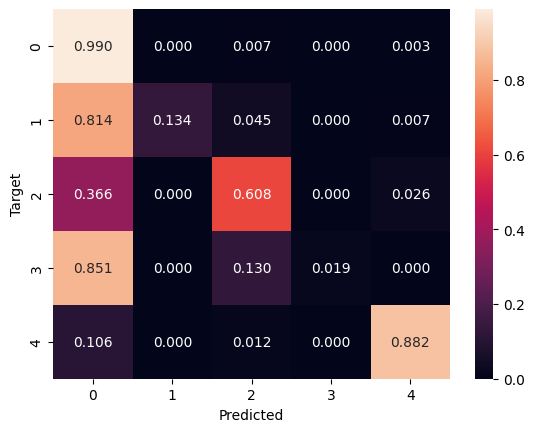

In [19]:
y_true = []
y_pred = []

testdata = teststreamer.stream()
for _ in range(len(teststreamer)):
    X, y = next(testdata)
    yhat = model(X)
    yhat = yhat.argmax(dim=1) # we get the one with the highest probability
    y_pred.append(yhat.cpu().tolist())
    y_true.append(y.cpu().tolist())

yhat = [x for y in y_pred for x in y]
y = [x for y in y_true for x in y]

cfm = confusion_matrix(y, yhat)
cfm = cfm / np.sum(cfm, axis=1, keepdims=True)

plot = sns.heatmap(cfm, annot=cfm, fmt=".3f")
plot.set(xlabel="Predicted", ylabel="Target")

[Text(0.5, 23.52222222222222, 'Predicted'),
 Text(50.722222222222214, 0.5, 'Target')]

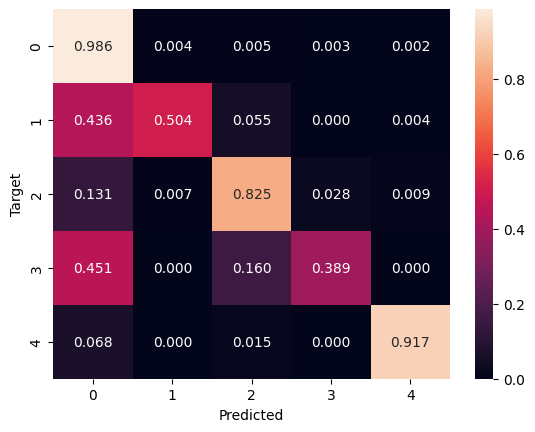

In [22]:
y_true = []
y_pred = []

testdata = teststreamer.stream()
for _ in range(len(teststreamer)):
    X, y = next(testdata)
    yhat = model(X)
    yhat = yhat.argmax(dim=1) # we get the one with the highest probability
    y_pred.append(yhat.cpu().tolist())
    y_true.append(y.cpu().tolist())

yhat = [x for y in y_pred for x in y]
y = [x for y in y_true for x in y]

cfm = confusion_matrix(y, yhat)
cfm = cfm / np.sum(cfm, axis=1, keepdims=True)

plot = sns.heatmap(cfm, annot=cfm, fmt=".3f")
plot.set(xlabel="Predicted", ylabel="Target")